In [61]:
import os
import json
import wandb
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import plotly.express as px
import plotly.graph_objects as go
import warnings
warnings.filterwarnings('ignore')
# Set seed
np.random.seed(42)

# set font to 12 and times new roman

plt.rcParams.update({'font.size': 12})
plt.rcParams["font.family"] = "Times New Roman"

sys.path.append('../')
from utils.data_utils import *


In [2]:
from utils.paths import EXPERIMENT_WANDB, SYNTHESIS_WANDB, CLEAN_DATA_DIR


In [3]:

os.chdir(r"..") # should be the git repo root directory, checking below:
print("Current working directory: " + os.getcwd())
assert os.getcwd()[-8:] == "WattCast"

Current working directory: /Users/nikolaushouben/Desktop/WattCast


## Results imports


### Grabbing all metrics from all runs from wandb

In [107]:



# Getting runs from experiments wandb project
api = wandb.Api()
runs = api.runs(EXPERIMENT_WANDB)


name_id_dict = get_run_name_id_dict(runs)

In [108]:
name_id_dict

{'4_neighborhood_neighborhood_2': 'thhudch0',
 '4_neighborhood_neighborhood_0': 'rf380mj3',
 '3_village_village_1': 'vxt8vyn2',
 '2_town_town_2': 'uhxxlr1z',
 '1_county_Sacramento': 'fnysqjff',
 '5_building_building_2': 'rmbiwgai',
 '3_village_village_0': 'nn6i7pep',
 '2_town_town_1': 'huyublbt',
 '1_county_Los_Angeles': '33cewqla',
 '5_building_building_1': 'fvtcb87c',
 '4_neighborhood_neighborhood_1': 'p4bjk8uq',
 '2_town_town_0': '3oygouo1',
 '1_county_New_York': '1_county_New_York',
 '3_village_village_2': '3_village_village_2'}

# Paper Figures & Tables

### Mappings for plotting shapes and colors

In [109]:
model2shape = {
    'RandomForest': 'o',
    'LightGBMModel': 's',
    'XGBModel': 'D',
    'BlockRNNModel': 'x',
    'NBEATSModel': '^',
    'TFTModel': 'v',
    'LinearRegressionModel': '*',
    '48-Hour Persistence': 'P'
}


model2color = {
    'RandomForest': 'blue',
    'LightGBMModel': 'orange',
    'XGBModel': 'green',
    'BlockRNNModel': 'red',
    'NBEATSModel': 'purple',
    'TFTModel': 'pink',
    'LinearRegressionModel': 'brown',
    '48-Hour Persistence': 'black'
}


shape2model = {v: k for k, v in model2shape.items()}


metric_dict = {'mape': 'Mean Absolute Percentage Error (MAPE)',
               'rmse': 'Root Mean Squared Error (RMSE)',
                'mae': 'Mean Absolute Error (MAE)',
                'smape': 'Symmetric Mean Absolute Percentage Error (SMAPE)',
                'rmse_skill_score': 'RMSE Skill Score',
                'r2_score': 'R2 Score',
                "nle": "Net Load Error (NLE)"
                }

season2color = {'Summer': 'orange', 'Winter': 'blue'}
color2season = {v: k for k, v in season2color.items()}

horizon2color = {'Ground Truth': 'black',
                '1 Hours Ahead': 'blue',
                '4 Hours Ahead': 'green',
                '8 Hours Ahead': 'orange',
                '24 Hours Ahead': 'red',
                '48 Hours Ahead': 'purple'}


model_groups = {'Tree-based': ['RandomForest', 'LightGBMModel', 'XGBModel'],
                'Neural Network': ['BlockRNNModel', 'NBEATSModel', 'TFTModel'],
                'Benchmark': ['LinearRegressionModel', '48-Hour Persistence']}


model2group = {}
for group, models in model_groups.items():
    for model in models:
        model2group[model] = group


group2shape = {'Tree-based': 'x', 'Neural Network': 'o', 'Benchmark': 's'}
shape2group = {v: k for k, v in group2shape.items()}

group2color = {'Tree-based': 'blue', 'Neural Network': 'red', 'Benchmark': 'black'}
color2group = {v: k for k, v in group2color.items()}



scale2unit = {"1_county": "GW", "2_town": "MW", "3_village": "kW", "4_neighborhood": "kW", "5_building": "W"}

In [110]:
dfs_sorted = {}
for name, run_id in name_id_dict.items():
    try:
        run_path = f'wattcast/{EXPERIMENT_WANDB}/run-{run_id}-Metrics_Table:latest'
        artifact = synthesis_run.use_artifact(f'{run_path}', type='run_table')
        artifact_dir = artifact.download()
        with open(os.path.join(artifact_dir, os.listdir(artifact_dir)[0])) as f:
            data = json.load(f)
        df_metrics = pd.DataFrame(data['data'], columns=data['columns'])
        df = df_metrics.sort_values(by=['model', 'season'])
        dfs_sorted[name] = df
    except:
        print(f'Error in {name}')


wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


## Per Model

### Plot 1: Skill Score vs Horizon for each model and season

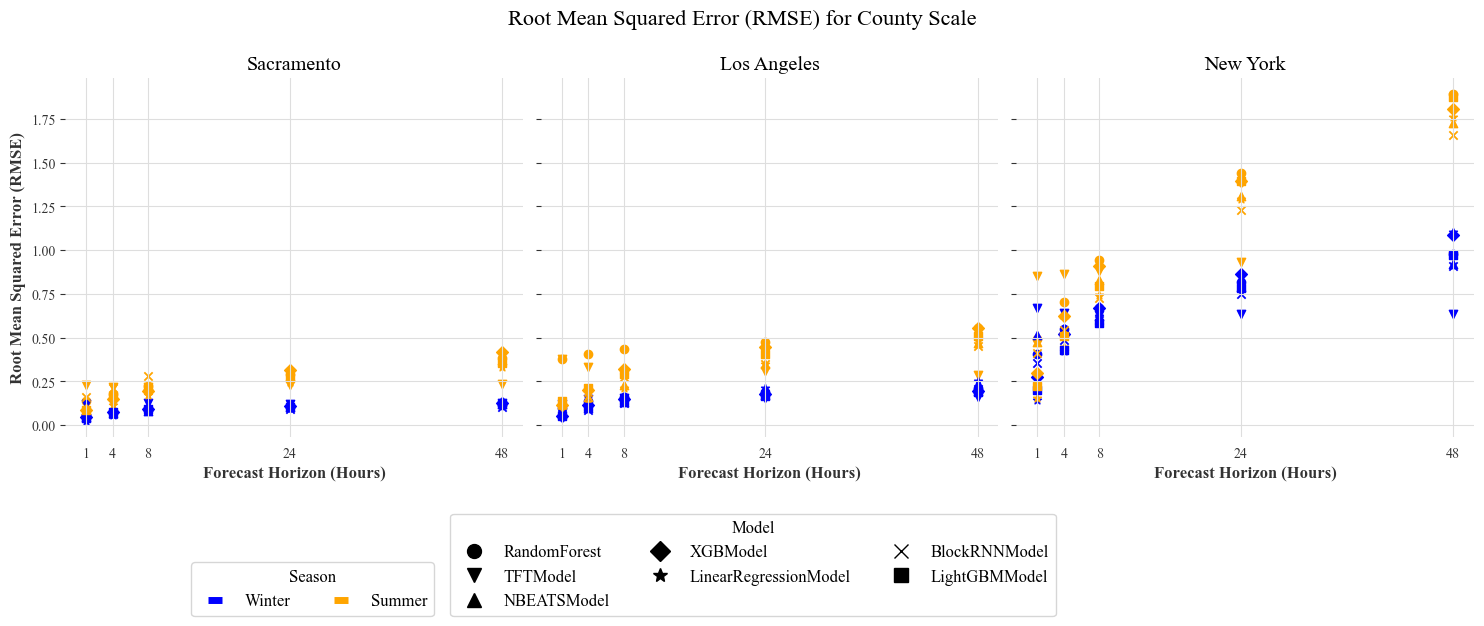

In [131]:
# Set these:

spatial_scale = '1_county' # options are '1_county', '2_town', '3_village', '4_neighborhood', '5_building'
metric_of_interest = 'rmse' # options are 'mape', 'rmse', 'mae', 'smape','r2_score', 'max_peak_error', 'mean_n_peak_error', 'nle', or any of their skill scores

dfs_sorted_plot = dfs_sorted.copy()
keys = list(dfs_sorted_plot.keys())
for key in keys:
    if not spatial_scale in key:
        del dfs_sorted_plot[key]



fig, axs = plt.subplots(1, len(dfs_sorted_plot), figsize=(5*(len(dfs_sorted_plot)),5), sharex=True, sharey=True)

    
axs = axs.ravel()

# Create a list to store the handles and labels for the legend
model_handles = []
season_handles = []
model_labels = []
season_labels = []

grey_color = 'black'
for i, ax in enumerate(axs):

    name, df = list(dfs_sorted_plot.items())[i]
    df['color'] = df['season'].map(season2color)
    df['shape'] = df['model'].map(model2shape)

    # exclude 24 hour persistence
    df = df.loc[df['model'] != '48-Hour Persistence']

    for shape in set(df['shape']):
        for color in set(df.loc[df['shape'] == shape, 'color']):
            # Plot x and y data
            x = df.loc[(df['shape'] == shape) & (df['color'] == color), 'horizon_in_hours']
            y = df.loc[(df['shape'] == shape) & (df['color'] == color), metric_of_interest]
            ax.scatter(x, y, c=color, marker=shape)

            # Add to model and season legends
            model_label = shape2model[shape]
            season_label = color2season[color]
            if model_label not in model_labels:
                model_handle = mlines.Line2D([], [], color=grey_color, marker=shape, linestyle='None', markersize=10, label=model_label)
                model_handles.append(model_handle)
                model_labels.append(model_label)
            if season_label not in season_labels:
                season_handle = mlines.Line2D([], [], color=color, marker='_', linestyle='None', markersize=10,markeredgewidth=5,  label=season_label)
                season_handles.append(season_handle)
                season_labels.append(season_label)

    # Set the x ticks and labels
    ax.set_xticks([1, 4, 8, 24, 48])
    ax.set_xlabel('Forecast Horizon (Hours)')

    # Set the y label
    if i == 0:
        ax.set_ylabel(f'{metric_dict[metric_of_interest]}')

    # Set the title for each subplot
    ax.set_title(f'{" ".join(name.split("_")[2:])}')

    # Add grid for each subplot
    ax.grid(True)

    # Add a horizontal red dashed line at y = 0
    if "skill" in metric_of_interest:
        ax.axhline(y=0, color='red', linestyle='..')

# Create a single legend for all subplots
fig.legend(handles=model_handles, labels=model_labels, title='Model', loc='lower left', bbox_to_anchor=(0.3, -0.25), ncol=len(model_handles)//2, frameon=True)
fig.legend(handles=season_handles, labels=season_labels, title='Season', loc='lower right', bbox_to_anchor=(0.3, -0.25), ncol=len(season_handles), frameon=True)

# Set the title for each subplot
fig.suptitle(f'{metric_dict[metric_of_interest]} for {spatial_scale.split("_")[1].capitalize()} Scale', fontsize=16)

# Adjust the spacing between subplots
fig.tight_layout()

# Show the plot
plt.show()


In [78]:
from utils.paths import RESULTS_DIR

FIG_DIR = os.path.join(RESULTS_DIR, 'figs')

create_directory(FIG_DIR)

Directory created: /Users/nikolaushouben/Desktop/WattCast/results/figs


In [79]:
for format in ['png', 'pdf']:
    fig.savefig(os.path.join(FIG_DIR,f'{spatial_scale}_{metric_of_interest}.{format}'), bbox_inches='tight')

### Plot 2: Side by side comparison of models for each season for a selected week

In [85]:
# set these
season = 'Winter'
algorithm = 'XGBModel'

scale = "1_county"
location = "Los_Angeles"
unit = scale2unit[scale]



In [86]:
files = get_file_names(EXPERIMENT_WANDB, name_id_dict, spatial_scale=scale, location=location,season= season)

side_by_side_plots_dict= download_plotly_plots(get_latest_plotly_plots(files))

df_all = side_by_side_df(side_by_side_plots_dict)

Plot

In [87]:
# reordering columns

import re
def extract_horizon(col):
    match = re.search(r'Horizon: (\d+)', col)
    return int(match.group(1)) if match else float('inf')

# Sort the columns by the extracted horizon number
sorted_columns = sorted(df_all.columns, key=extract_horizon)

# Reorder the DataFrame using the sorted columns
df_all = df_all[sorted_columns]

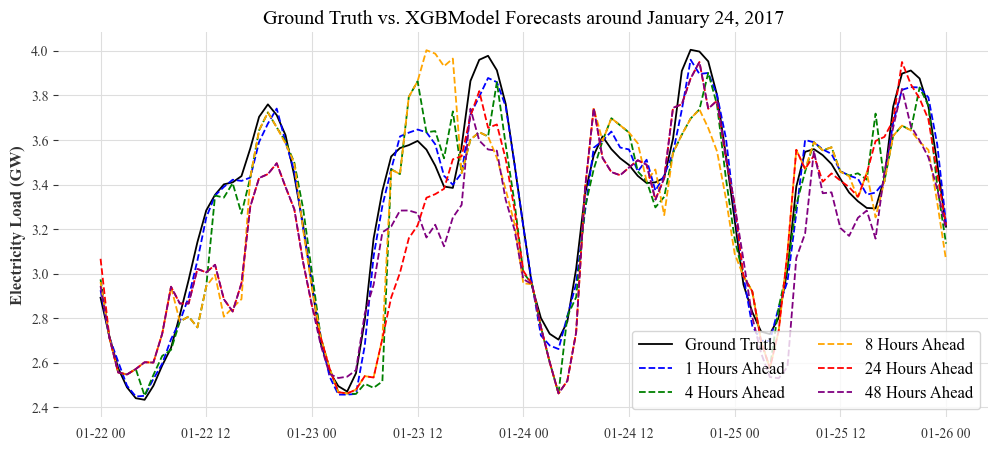

In [88]:
# find the day with the highest peak
dt_highest_peak = pd.Timestamp(df_all['Ground Truth'].idxmax()).date()
dt_start = dt_highest_peak - pd.Timedelta(days=2)
dt_end = dt_highest_peak + pd.Timedelta(days=2)

df_all.index = pd.to_datetime(df_all.index)
df_all = df_all.loc[dt_start:dt_end]


fig, ax = plt.subplots(figsize=(12,5))

df_preds = df_all.filter(like=algorithm)
df_preds.columns = [col.split(':')[-1][1:] + ' Ahead' for col in df_preds.columns]
df_gt = df_all.filter(like='Ground')
df_plot = pd.concat([df_gt, df_preds], axis=1)
for col in df_plot.columns:
    ax.plot(df_plot[col], label=col, color=horizon2color[col], linestyle= 'solid' if col == 'Ground Truth' else "dashed")

ax.set_ylabel(f'Electricity Load ({unit})')
ax.set_title(f'Ground Truth vs. {algorithm} Forecasts around {dt_highest_peak.strftime("%B %d, %Y")}')

ax.grid(True, axis='x')
ax.legend(frameon=True, ncol = 2, loc = "lower right")

In [89]:
for format in ['png', 'pdf']:
    fig.savefig(os.path.join(FIG_DIR,f'plot_3_side-by-side_horizons_heat_wave_{scale}_{location}_{season}_{algorithm}.{format}'), bbox_inches='tight')

#wandb.log({f'plot_3_side-by-side_horizons_heat_wave_{run_to_visualize}_{season}_{algorithm}': wandb.Image(fig)})

### Plot 3: Comparing Spatial Scales (mean of seasons and datasets)

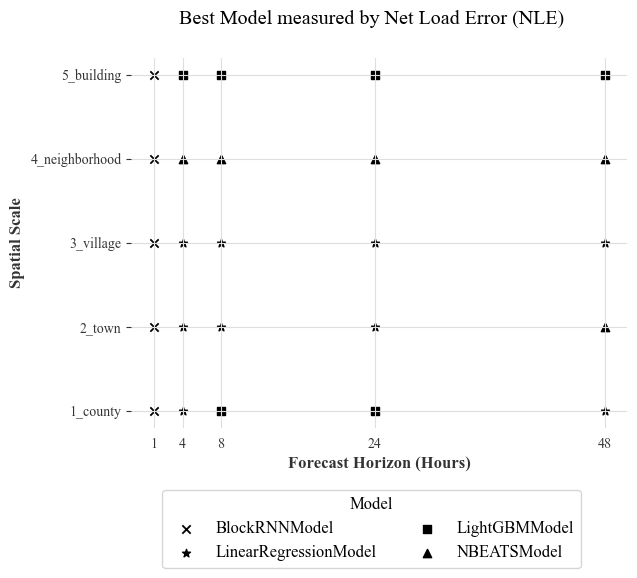

In [130]:
metric_of_interest = 'nle'

df_metrics_all_scales = pd.DataFrame()

for scale, df in dfs_sorted.items():
    scale = "_".join(scale.split("_")[:2])
    df['scale'] = scale
    df_metrics_all_scales = df_metrics_all_scales.append(df)

# marginalize over the season
df_metrics_grouped = df_metrics_all_scales.groupby(['scale', 'model', 'horizon_in_hours']).mean()[[metric_of_interest]].reset_index()

# extract the model with the best performance for each scale and horizon
df_metrics_grouped = df_metrics_grouped.sort_values(by=['scale', metric_of_interest], ascending=False if "skill" in metric_of_interest else True)
df_metrics_grouped = df_metrics_grouped.drop_duplicates(subset=['scale', 'horizon_in_hours'], keep='first')
df_metrics_grouped = df_metrics_grouped.sort_values(by=['scale', 'horizon_in_hours'])
df_metrics_grouped = df_metrics_grouped.reset_index(drop=True)


# Define colors and shapes based on the season and model
df = df_metrics_grouped
fig, ax = plt.subplots()

# Create a list to store the handles and labels for the legend
legend_handles = []
legend_labels = []


# Map the colors and shapes to the DataFrame
df['shape'] = df['model'].map(model2shape)


for scale, df_scale in df.groupby('scale'): # this for loop is to make sure the order of scales is from county to neighborhood
    for shape in set(df_scale['shape']):
        x = df_scale.loc[(df_scale['shape'] == shape), 'horizon_in_hours']
        y = df_scale.loc[(df_scale['shape'] == shape), 'scale']
        label = f'{shape2model[shape]}'
        scatter = ax.scatter(x, y, marker=shape, label=label, color="black")
        if label not in legend_labels:
            legend_handles.append(scatter)
            legend_labels.append(label)

# Set the x ticks and labels
ax.set_xticks([1, 4, 8, 24, 48])
ax.set_xlabel('Forecast Horizon (Hours)')


ax.set_ylabel('Spatial Scale')

# Set the title for each subplot
fig.suptitle(f'Best Model measured by {metric_dict[metric_of_interest]}')

# Create a single legend for all subplots
fig.legend(handles=legend_handles, labels=legend_labels, title='Model', loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=2, frameon=True)


# Show the plot
plt.show()


In [ ]:

for format in ['png', 'pdf']:
    fig.savefig(os.path.join(os.getcwd(),'imgs','figures',f'plot_1_overview_across_scales_{metric_of_interest}.{format}'), bbox_inches='tight')

#wandb.log({f'plot_1_overview_across_scales_{metric_of_interest}': fig})

### Plot 4: Comparing Spatial Scales (mean of datasets per season)

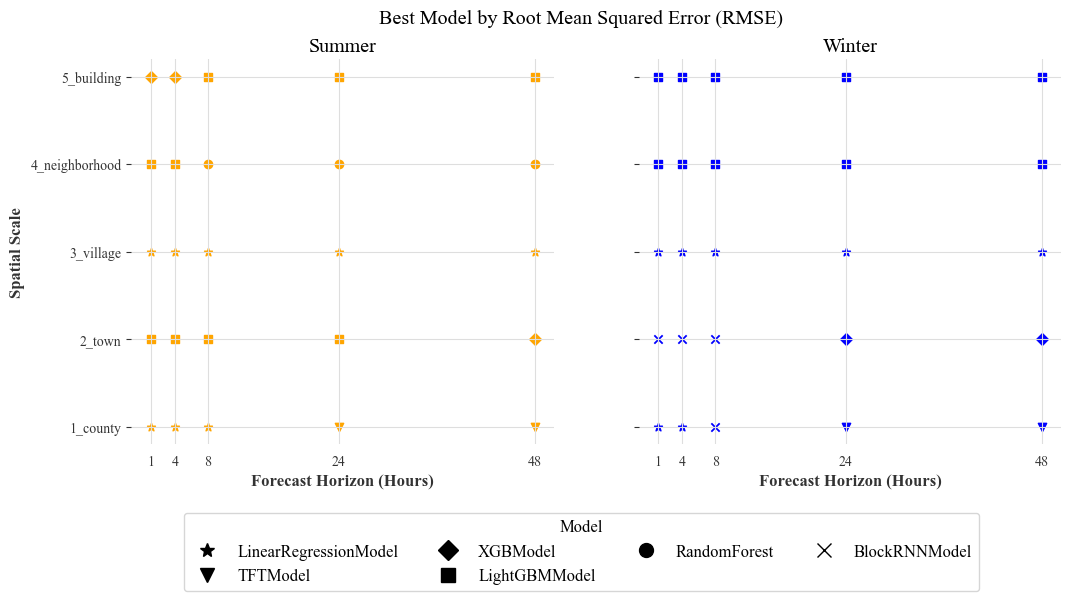

In [132]:
df_metrics_all_scales = pd.DataFrame()

for scale, df in dfs_sorted.items():
    scale = "_".join(scale.split("_")[:2])
    df['scale'] = scale
    df_metrics_all_scales = df_metrics_all_scales.append(df)

df_metrics_grouped = df_metrics_all_scales.groupby(['season', 'scale', 'model', 'horizon_in_hours']).mean()[[metric_of_interest]].reset_index()

season = 'Winter'

fig, axs = plt.subplots(1,2, figsize=(12,5), sharex=True, sharey=True)

axs = axs.ravel()
# Create a list to store the handles and labels for the legend
legend_handles = []
legend_labels = []

for i, ax in enumerate(axs):

    season = list(season2color.keys())[i]

    df_metrics_grouped_season = df_metrics_grouped.loc[df_metrics_grouped['season'] == season]

    df = get_best_model_per_scale_and_horizon(df_metrics_grouped_season, metric_of_interest)

    shape2model = {v: k for k, v in model2shape.items()}

    # Map the colors and shapes to the DataFrame
    df['shape'] = df['model'].map(model2shape)

    for scale, df_scale in df.groupby('scale'):
        for shape in set(df_scale['shape']):
            x = df_scale.loc[(df_scale['shape'] == shape), 'horizon_in_hours']
            y = df_scale.loc[(df_scale['shape'] == shape), 'scale']
            label = f'{shape2model[shape]}'
            if season == 'Winter':
                ax.scatter(x, y, marker=shape, label=label, color=season2color[season])
            else:
                ax.scatter(x, y, marker=shape, label=label, color=season2color[season])
            if label not in legend_labels:
                model_handle = mlines.Line2D([], [], color="black", marker=shape, linestyle='None', markersize=10, label=model_label)
                legend_labels.append(label)
                legend_handles.append(model_handle)

    # Set the x ticks and labels
    ax.set_xticks([1, 4, 8, 24, 48])
    ax.set_xlabel('Forecast Horizon (Hours)')
    



    # Set the y label
    if i == 0:
        ax.set_ylabel('Spatial Scale')

    # Set the title for each subplot
    ax.set_title(f'{season}')


# Create a single legend for all subplots
fig.legend(handles=legend_handles, labels=legend_labels, title='Model', loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=4, frameon=True)

fig.suptitle(f'Best Model by {metric_dict[metric_of_interest]}')
# Adjust the spacing between subplots
#fig.tight_layout()

# Show the plot
plt.show()


## Tree-based models vs. Deep learning models

### Plot 1

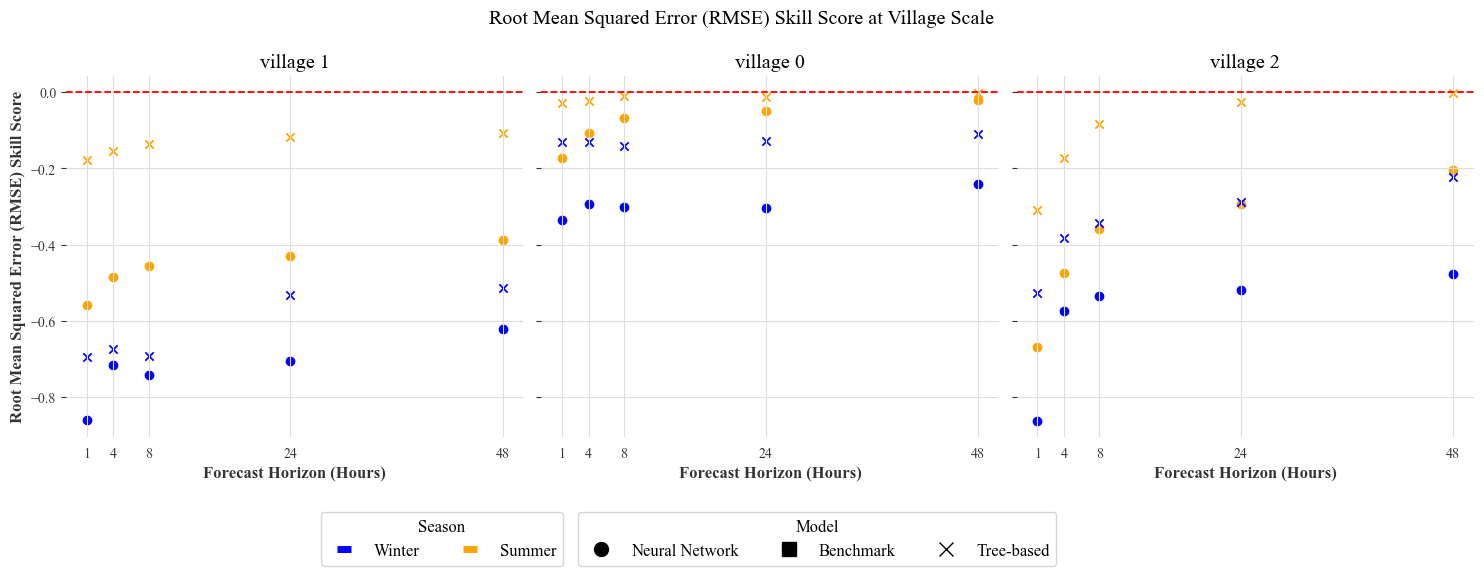

In [156]:
# Set these:

spatial_scale = '3_village'
metric_of_interest = 'rmse_skill'

dfs_sorted_plot = dfs_sorted.copy()
keys = list(dfs_sorted_plot.keys())
for key in keys:
    if not spatial_scale in key:
        del dfs_sorted_plot[key]


# Define colors and shapes based on the season and model
color2season = {v: k for k, v in season2color.items()}
shape2model = {v: k for k, v in model2shape.items()}


fig, axs = plt.subplots(1, len(dfs_sorted_plot), figsize=(5*(len(dfs_sorted_plot)),5), sharex=True, sharey=True)
axs = axs.ravel()


# Create a list to store the handles and labels for the legend
model_handles = []
season_handles = []
model_labels = []
season_labels = []

for i, ax in enumerate(axs):
    # Map the colors and shapes to the DataFrame
    name, df = list(dfs_sorted_plot.items())[i]
    # exclude 24 hour persistence
    df = df.loc[df['model'] != '48-Hour Persistence']
    df['group'] = df['model'].map(model2group)
    df = df.groupby(['group', 'horizon_in_hours', 'season']).mean().reset_index()
    df['color'] = df['season'].map(season2color)
    df['shape'] = df['group'].map(group2shape)
    
    
    for shape in set(df['shape']):
        for color in set(df.loc[df['shape'] == shape, 'color']):
            x = df.loc[(df['shape'] == shape) & (df['color'] == color), 'horizon_in_hours']
            y = df.loc[(df['shape'] == shape) & (df['color'] == color), metric_of_interest]

            if shape != 's' and "skill" in metric_of_interest:
                ax.scatter(x, y, c=color, marker=shape)


            model_label = shape2group[shape]
            season_label = color2season[color]
            if model_label not in model_labels:
                model_handle = mlines.Line2D([], [], color=grey_color, marker=shape, linestyle='None', markersize=10, label=model_label)
                model_handles.append(model_handle)
                model_labels.append(model_label)
            if season_label not in season_labels:
                season_handle = mlines.Line2D([], [], color=color, marker='_', linestyle='None', markersize=10, markeredgewidth=5, label=season_label)
                season_handles.append(season_handle)
                season_labels.append(season_label)

    # Set the x ticks and labels
    ax.set_xticks([1, 4, 8, 24, 48])
    ax.set_xlabel('Forecast Horizon (Hours)')

    # Set the y label
    if i == 0:
        if "skill" in metric_of_interest:
            ax.set_ylabel(f'{metric_dict[metric_of_interest.split("_")[0]]+ " Skill Score"}')
        else:
            ax.set_ylabel(f'{metric_dict[metric_of_interest]}')

    # Set the title for each subplot
    ax.set_title(f'{" ".join(name.split("_")[2:])}')

    # Add grid for each subplot
    ax.grid(True)

    # Add a horizontal red dashed line at y = 0
    if "skill" in metric_of_interest:
        ax.axhline(y=0, color='red', linestyle='--')

# Create a single legend for all subplots
#fig.legend(handles=legend_handles, labels=legend_labels, title='Model', loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=5, frameon=True)

fig.legend(handles=model_handles, labels=model_labels, title='Model', loc='lower center', bbox_to_anchor=(0.55, -0.15), ncol=len(model_handles), frameon=True)
fig.legend(handles=season_handles, labels=season_labels, title='Season', loc='lower center', bbox_to_anchor=(0.3, -0.15), ncol=len(season_handles), frameon=True)

if "skill" in metric_of_interest:
    fig.suptitle(f'{metric_dict[metric_of_interest.split("_")[0]]} Skill Score at {spatial_scale.split("_")[1].capitalize()} Scale')
else:
    fig.suptitle(f'{metric_dict[metric_of_interest]} at {spatial_scale.split("_")[1].capitalize()} Scale')
# Adjust the spacing between subplots
fig.tight_layout()

# Show the plot
plt.show()


### Plot 3

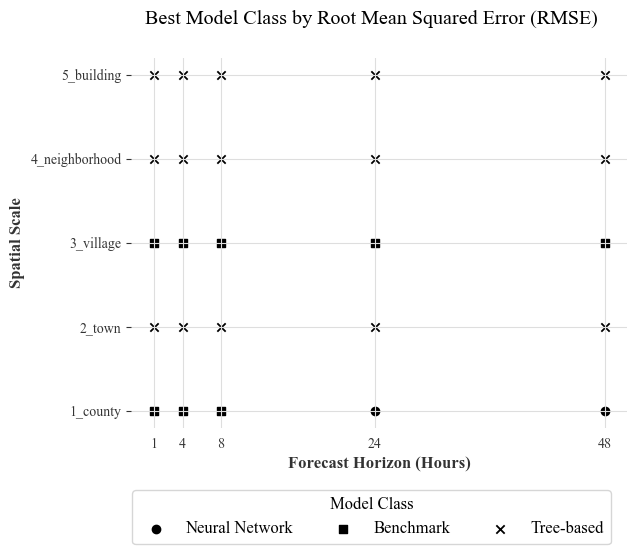

In [140]:
metric_of_interest = 'rmse' # options are 'mape', 'rmse', 'mae', 'smape', 'rmse_skill_score', 'r2_score', 'max_peak_error', 'mean_n_peak_error'

df_metrics_all_scales = pd.DataFrame()

for scale, df in dfs_sorted.items():
    scale = "_".join(scale.split("_")[:2])
    df['scale'] = scale
    df_metrics_all_scales = df_metrics_all_scales.append(df)

# marginalize over the season
df_metrics_grouped = df_metrics_all_scales.groupby(['scale', 'model', 'horizon_in_hours']).mean()[[metric_of_interest]].reset_index()

# extract the model with the best performance for each scale and horizon
df_metrics_grouped = df_metrics_grouped.sort_values(by=['scale', metric_of_interest], ascending=False if "skill" in metric_of_interest else True)
df_metrics_grouped = df_metrics_grouped.drop_duplicates(subset=['scale', 'horizon_in_hours'], keep='first')
df_metrics_grouped = df_metrics_grouped.sort_values(by=['scale', 'horizon_in_hours'])
df_metrics_grouped = df_metrics_grouped.reset_index(drop=True)


# Define colors and shapes based on the season and model
df = df_metrics_grouped
shape2model = {v: k for k, v in model2shape.items()}

fig, ax = plt.subplots()

# Create a list to store the handles and labels for the legend
legend_handles = []
legend_labels = []


# Map the colors and shapes to the DataFrame
df['group'] = df['model'].map(model2group)
df = df.groupby(['group', 'horizon_in_hours', 'scale']).mean().reset_index()

df['shape'] = df['group'].map(group2shape)

for scale, df_scale in df.groupby('scale'): # this for loop is to make sure the order of scales is from county to neighborhood
    for shape in set(df_scale['shape']):
        x = df_scale.loc[(df_scale['shape'] == shape), 'horizon_in_hours']
        y = df_scale.loc[(df_scale['shape'] == shape), 'scale']
        label = f'{shape2group[shape]}'
        scatter = ax.scatter(x, y, marker=shape, label=label, color="black")
        if label not in legend_labels:
            legend_handles.append(scatter)
            legend_labels.append(label)

# Set the x ticks and labels
ax.set_xticks([1, 4, 8, 24, 48])
ax.set_xlabel('Forecast Horizon (Hours)')

ax.set_ylabel('Spatial Scale')

# Set the title for each subplot
fig.suptitle(f'Best Model Class by {metric_dict[metric_of_interest]}')

# Create a single legend for all subplots
fig.legend(handles=legend_handles, labels=legend_labels, title='Model Class', loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=3, frameon=True)


# Show the plot
plt.show()


In [141]:

for format in ['png', 'pdf']:
    fig.savefig(os.path.join(FIG_DIR,f'plot_1_overview_tree_vs_nn__across_scales_{metric_of_interest}.{format}'), bbox_inches='tight')

#wandb.log({f'plot_1_overview_across_scales_{metric_of_interest}': fig})

# Net Load Error Plots

In [ ]:
from utils.paths import RESULTS_DIR

scale = "1_county"
location = "Los_Angeles"


pd.read_csv(os.path.join(RESULTS_DIR, 'nle_results', scale,  ))